In [1]:
from __future__ import absolute_import, division
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from trainingUtils import MultipleOptimizer, MultipleScheduler, compute_kernel, compute_mmd
from models import Decoder, SimpleEncoder,LocalDiscriminator,PriorDiscriminator,Classifier,SpeciesCovariate
# import argparse
import math
import numpy as np
import pandas as pd
import sys
import random
import os
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score,confusion_matrix
from scipy.stats import spearmanr,pearsonr
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy
import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')    

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = False

In [5]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

In [6]:
def compute_gradients(output, input):
    grads = torch.autograd.grad(output, input, create_graph=True)
    grads = grads[0].pow(2).mean()
    return grads

## Load data

In [7]:
# Read data
cmap = pd.read_csv('../preprocessing/preprocessed_data/all_cmap_landmarks.csv',index_col = 0)
gene_size = len(cmap.columns)
samples = cmap.index.values

## Train model

In [8]:
model_params = {'encoder_1_hiddens':[640,384],
                'encoder_2_hiddens':[640,384],
                'latent_dim': 292,
                #'decoder_hiddens':[384,640],
                'decoder_1_hiddens':[384,640],
                'decoder_2_hiddens':[384,640],
                'dropout_decoder':0.2,
                'dropout_encoder':0.1,
                'encoder_activation':torch.nn.ELU(),
                'decoder_activation':torch.nn.ELU(),
                'intermediateEncoder1':[292],
                'intermediateEncoder2':[292],
                'intermediate_latent':256,
                'intermediate_dropout':0.1,
                'state_class_hidden':[256,128,64],
                'state_class_drop_in':0.5,
                'state_class_drop':0.25,
                'no_states':2,
                'adv_class_hidden':[256,128,64],
                'adv_class_drop_in':0.3,
                'adv_class_drop':0.1,
                'no_adv_class':2,
                'adv_lr':0.001,
                'schedule_step_adv':200,
                'gamma_adv':0.5,
                'adv_penalnty':100,
                'reg_adv':1000,
                'encoding_lr':0.001,
                'schedule_step_enc':200,
                'gamma_enc':0.8,
                'batch_size_1':150,
                'batch_size_2':150,
                'batch_size_paired':90,
                'epochs':1000,
                'prior_beta':1.0,
                'no_folds':10,
                'intermediate_reg':1e-02,
                'state_class_reg':1e-02,
                'enc_l2_reg':0.01,
                'dec_l2_reg':0.01,
                'lambda_mi_loss':100,
                'cosine_loss': 10,
                'reg_classifier': 1000,
                'similarity_reg' : 10,
                'autoencoder_wd':0,
                'adversary_wd':0}

In [9]:
class_criterion = torch.nn.CrossEntropyLoss()
NUM_EPOCHS= model_params['epochs']
bs_1 = model_params['batch_size_1']
bs_2 =  model_params['batch_size_2']
bs_paired =  model_params['batch_size_paired']

In [10]:
#pretrained_adv_class = torch.load('../results/MI_results/models/CPA_approach/pre_trained_classifier_adverse_0.pt')

In [14]:
valR2 = []
valPear = []
valMSE =[]
valSpear = []
valAccuracy = []


valPearDirect = []
valSpearDirect = []
valAccDirect = []

valR2_1 = []
valPear_1 = []
valMSE_1 =[]
valSpear_1 = []
valAccuracy_1 = []

valR2_2 = []
valPear_2 = []
valMSE_2 =[]
valSpear_2 = []
valAccuracy_2 = []

crossCorrelation = []

valF1 = []
valClassAcc = []

for i in range(10):
    # Network
    decoder_1 = Decoder(model_params['intermediate_latent'],model_params['decoder_1_hiddens'],gene_size,
                        dropRate=model_params['dropout_decoder'], 
                        activation=model_params['decoder_activation']).to(device)
    decoder_2 = Decoder(model_params['intermediate_latent'],model_params['decoder_2_hiddens'],gene_size,
                        dropRate=model_params['dropout_decoder'], 
                        activation=model_params['decoder_activation']).to(device)
    #decoder = Decoder(model_params['intermediate_latent'],model_params['decoder_hiddens'],gene_size,
    #                    dropRate=model_params['dropout_decoder'], 
    #                    activation=model_params['decoder_activation']).to(device)
    encoder_1 = SimpleEncoder(gene_size,model_params['encoder_1_hiddens'],model_params['latent_dim'],
                              dropRate=model_params['dropout_encoder'], 
                              activation=model_params['encoder_activation']).to(device)
    encoder_2 = SimpleEncoder(gene_size,model_params['encoder_2_hiddens'],model_params['latent_dim'],
                                  dropRate=model_params['dropout_encoder'], 
                                  activation=model_params['encoder_activation']).to(device)
    prior_d = PriorDiscriminator(model_params['latent_dim']).to(device)
    local_d = LocalDiscriminator(model_params['latent_dim'],model_params['latent_dim']).to(device)
    classifier = Classifier(in_channel=model_params['intermediate_latent'],
                            hidden_layers=model_params['state_class_hidden'],
                            num_classes=model_params['no_states'],
                            drop_in=model_params['state_class_drop_in'],
                            drop=model_params['state_class_drop']).to(device)
    encoder_interm_1 = SimpleEncoder(model_params['latent_dim'],
                                     model_params['intermediateEncoder1'],
                                     model_params['intermediate_latent'],
                                     dropRate=model_params['intermediate_dropout'], 
                                     activation=model_params['encoder_activation']).to(device)
    encoder_interm_2 = SimpleEncoder(model_params['latent_dim'],
                                     model_params['intermediateEncoder2'],
                                     model_params['intermediate_latent'],
                                     dropRate=model_params['intermediate_dropout'], 
                                     activation=model_params['encoder_activation']).to(device)
    prior_d_2 = PriorDiscriminator(model_params['intermediate_latent']).to(device)
    local_d_2 = LocalDiscriminator(model_params['intermediate_latent'],model_params['intermediate_latent']).to(device)
    adverse_classifier = Classifier(in_channel=model_params['latent_dim'],
                                    hidden_layers=model_params['adv_class_hidden'],
                                    num_classes=model_params['no_adv_class'],
                                    drop_in=model_params['adv_class_drop_in'],
                                    drop=model_params['adv_class_drop']).to(device)
    #adverse_classifier.load_state_dict(pretrained_adv_class.state_dict())
    
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i,index_col=0)
    trainInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%i,index_col=0)
    trainInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%i,index_col=0)
    
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)
    valInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i,index_col=0)
    valInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i,index_col=0)
    
    N_paired = len(trainInfo_paired)
    N_1 = len(trainInfo_1)
    N_2 = len(trainInfo_2)
    N = N_1
    if N_2>N:
        N=N_2
    
    allParams = list(decoder_1.parameters()) +list(decoder_2.parameters())
    #allParams = list(decoder.parameters())
    allParams = allParams + list(encoder_1.parameters()) +list(encoder_2.parameters())
    allParams = allParams + list(encoder_interm_1.parameters()) +list(encoder_interm_2.parameters())
    allParams = allParams + list(prior_d.parameters()) + list(local_d.parameters())
    allParams = allParams + list(prior_d_2.parameters()) + list(local_d_2.parameters())
    allParams = allParams + list(classifier.parameters())
    optimizer = torch.optim.Adam(allParams, lr= model_params['encoding_lr'],
                                 weight_decay=model_params['autoencoder_wd'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=model_params['schedule_step_enc'],
                                                gamma=model_params['gamma_enc'])
    optimizer_adv = torch.optim.Adam(adverse_classifier.parameters(), lr= model_params['adv_lr'], 
                                     weight_decay=model_params['adversary_wd'])
    
    scheduler_adv = torch.optim.lr_scheduler.StepLR(optimizer_adv,
                                                    step_size=model_params['schedule_step_adv'],
                                                    gamma=model_params['gamma_adv'])
    for e in range(0, NUM_EPOCHS):
        decoder_1.train()
        decoder_2.train()
        encoder_1.train()
        encoder_2.train()
        encoder_interm_1.train()
        encoder_interm_2.train()
        prior_d.train()
        local_d.train()
        classifier.train()
        adverse_classifier.train()
        prior_d_2.train()
        local_d_2.train()
        
        trainloader_1 = getSamples(N_1, bs_1)
        len_1 = len(trainloader_1)
        trainloader_2 = getSamples(N_2, bs_2)
        len_2 = len(trainloader_2)
        trainloader_paired = getSamples(N_paired, bs_paired)
        len_paired = len(trainloader_paired)

        lens = [len_1,len_2,len_paired]
        maxLen = np.max(lens)
        
        iteration = 1

        if maxLen>lens[0]:
            trainloader_suppl = getSamples(N_1, bs_1)
            for jj in range(maxLen-lens[0]):
                trainloader_1.insert(jj,trainloader_suppl[jj])
        
        if maxLen>lens[1]:
            trainloader_suppl = getSamples(N_2, bs_2)
            for jj in range(maxLen-lens[1]):
                trainloader_2.insert(jj,trainloader_suppl[jj])
        
        if maxLen>lens[2]:
            trainloader_suppl = getSamples(N_paired, bs_paired)
            for jj in range(maxLen-lens[2]):
                trainloader_paired.insert(jj,trainloader_suppl[jj])
        #for dataIndex in trainloader:
        for j in range(maxLen):
            dataIndex_1 = trainloader_1[j]
            dataIndex_2 = trainloader_2[j]
            dataIndex_paired = trainloader_paired[j]
            
            df_pairs = trainInfo_paired.iloc[dataIndex_paired,:]
            df_1 = trainInfo_1.iloc[dataIndex_1,:]
            df_2 = trainInfo_2.iloc[dataIndex_2,:]
            paired_inds = len(df_pairs)
            
            
            X_1 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.x']].values,
                                                 cmap.loc[df_1.sig_id].values))).float().to(device)
            X_2 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.y']].values,
                                                 cmap.loc[df_2.sig_id].values))).float().to(device)
            
            
            conditions = np.concatenate((df_pairs.conditionId.values,
                                         df_1.conditionId.values,
                                         df_pairs.conditionId.values,
                                         df_2.conditionId.values))
            size = conditions.size
            conditions = conditions.reshape(size,1)
            conditions = conditions == conditions.transpose()
            conditions = conditions*1
            mask = torch.tensor(conditions).to(device).detach()
            pos_mask = mask
            neg_mask = 1 - mask
            log_2 = math.log(2.)
            optimizer.zero_grad()
            optimizer_adv.zero_grad()
            
            z_base_1 = encoder_1(X_1)
            z_base_2 = encoder_2(X_2)
            latent_base_vectors = torch.cat((z_base_1, z_base_2), 0)
            labels_adv = adverse_classifier(latent_base_vectors)
            true_labels = torch.cat((torch.ones(z_base_1.shape[0]),
                                         torch.zeros(z_base_2.shape[0])),0).long().to(device)
            _, predicted = torch.max(labels_adv, 1)
            predicted = predicted.cpu().numpy()
            cf_matrix = confusion_matrix(true_labels.cpu().numpy(),predicted)
            tn, fp, fn, tp = cf_matrix.ravel()
            f1_basal_trained = 2*tp/(2*tp+fp+fn)
            adv_entropy = class_criterion(labels_adv,true_labels)
            adversary_drugs_penalty = compute_gradients(labels_adv.sum(), latent_base_vectors)
            loss_adv = adv_entropy + model_params['adv_penalnty'] * adversary_drugs_penalty
            loss_adv.backward()
            optimizer_adv.step()
            optimizer.zero_grad()
            
            z_base_1 = encoder_1(X_1)
            z_base_2 = encoder_2(X_2)
            latent_base_vectors = torch.cat((z_base_1, z_base_2), 0)
            
            z_un = local_d(latent_base_vectors)
            res_un = torch.matmul(z_un, z_un.t())
            
            z_1 = encoder_interm_1(z_base_1)
            z_2 = encoder_interm_2(z_base_2)
            latent_vectors = torch.cat((z_1, z_2), 0)
            z_un_interm = local_d_2(latent_vectors)
            res_un_interm = torch.matmul(z_un_interm, z_un_interm.t())
            
            y_pred_1 = decoder_1(z_1)
            fitLoss_1 = torch.mean(torch.sum((y_pred_1 - X_1)**2,dim=1))
            L2Loss_1 = encoder_1.L2Regularization(model_params['enc_l2_reg']) + decoder_1.L2Regularization(model_params['dec_l2_reg'])
            loss_1 = fitLoss_1 + L2Loss_1
            
            y_pred_2 = decoder_2(z_2)
            fitLoss_2 = torch.mean(torch.sum((y_pred_2 - X_2)**2,dim=1))
            L2Loss_2 = encoder_2.L2Regularization(model_params['enc_l2_reg']) + decoder_2.L2Regularization(model_params['dec_l2_reg'])
            loss_2 = fitLoss_2 + L2Loss_2
            
            silimalityLoss = torch.mean(torch.sum((z_base_1[0:paired_inds,:] - z_base_2[0:paired_inds,:])**2,dim=-1))
            cosineLoss = torch.nn.functional.cosine_similarity(z_base_1[0:paired_inds,:],z_base_2[0:paired_inds,:],dim=-1).mean()
            
            p_samples = res_un * pos_mask.float()
            q_samples = res_un * neg_mask.float()
            Ep = log_2 - F.softplus(- p_samples)
            Eq = F.softplus(-q_samples) + q_samples - log_2
            Ep = (Ep * pos_mask.float()).sum() / pos_mask.float().sum()
            Eq = (Eq * neg_mask.float()).sum() / neg_mask.float().sum()
            mi_loss = Eq - Ep
            prior = torch.rand_like(latent_base_vectors)
            term_a = torch.log(prior_d(prior)).mean()
            term_b = torch.log(1.0 - prior_d(latent_base_vectors)).mean()
            prior_loss = -(term_a + term_b) * model_params['prior_beta']
            
            p_samples_interm = res_un_interm * pos_mask.float()
            q_samples_interm = res_un_interm * neg_mask.float()
            Ep_interm = log_2 - F.softplus(- p_samples_interm)
            Eq_interm = F.softplus(-q_samples_interm) + q_samples_interm - log_2
            Ep_interm = (Ep_interm * pos_mask.float()).sum() / pos_mask.float().sum()
            Eq_interm = (Eq_interm * neg_mask.float()).sum() / neg_mask.float().sum()
            mi_loss_interm = Eq_interm - Ep_interm
            prior_interm = torch.rand_like(latent_vectors)
            term_a_interm = torch.log(prior_d_2(prior_interm)).mean()
            term_b_interm = torch.log(1.0 - prior_d_2(latent_vectors)).mean()
            prior_loss_interm = -(term_a_interm + term_b_interm) * model_params['prior_beta']

            # Classification loss
            labels = classifier(latent_vectors)
            true_labels = torch.cat((torch.ones(z_1.shape[0]),
                                     torch.zeros(z_2.shape[0])),0).long().to(device)
            entropy = class_criterion(labels,true_labels)
            _, predicted = torch.max(labels, 1)
            predicted = predicted.cpu().numpy()
            cf_matrix = confusion_matrix(true_labels.cpu().numpy(),predicted)
            tn, fp, fn, tp = cf_matrix.ravel()
            f1_latent = 2*tp/(2*tp+fp+fn)
            
            # Remove signal from z_basal
            labels_adv = adverse_classifier(latent_base_vectors)
            true_labels = torch.cat((torch.ones(z_base_1.shape[0]),
                                     torch.zeros(z_base_2.shape[0])),0).long().to(device)
            adv_entropy = class_criterion(labels_adv,true_labels)
            _, predicted = torch.max(labels_adv, 1)
            predicted = predicted.cpu().numpy()
            cf_matrix = confusion_matrix(true_labels.cpu().numpy(),predicted)
            tn, fp, fn, tp = cf_matrix.ravel()
            f1_basal = 2*tp/(2*tp+fp+fn)
            
            #decoder.L2Regularization(model_params['dec_l2_reg'])
            loss = loss_1 + loss_2 + model_params['similarity_reg'] * silimalityLoss +\
                   model_params['lambda_mi_loss']*mi_loss_interm + prior_loss_interm +\
                   model_params['lambda_mi_loss']*mi_loss + prior_loss +\
                   model_params['reg_classifier']*entropy - model_params['reg_adv']*adv_entropy +\
                   classifier.L2Regularization(model_params['state_class_reg']) +\
                   encoder_interm_1.L2Regularization(model_params['intermediate_reg'])+\
                   encoder_interm_2.L2Regularization(model_params['intermediate_reg'])-\
                   model_params['cosine_loss'] * cosineLoss

            loss.backward()
            optimizer.step()
            
        
            pearson_1 = pearson_r(y_pred_1.detach().flatten(), X_1.detach().flatten())
            r2_1 = r_square(y_pred_1.detach().flatten(), X_1.detach().flatten())
            mse_1 = torch.mean(torch.mean((y_pred_1.detach() - X_1.detach())**2,dim=1))
        
            pearson_2 = pearson_r(y_pred_2.detach().flatten(), X_2.detach().flatten())
            r2_2 = r_square(y_pred_2.detach().flatten(), X_2.detach().flatten())
            mse_2 = torch.mean(torch.mean((y_pred_2.detach() - X_2.detach())**2,dim=1))
        
        scheduler_adv.step()
        if (e>=0):
            scheduler.step()
            outString = 'Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(i+1,e+1,NUM_EPOCHS)
            outString += ', r2_1={:.4f}'.format(r2_1.item())
            outString += ', pearson_1={:.4f}'.format(pearson_1.item())
            outString += ', MSE_1={:.4f}'.format(mse_1.item())
            outString += ', r2_2={:.4f}'.format(r2_2.item())
            outString += ', pearson_2={:.4f}'.format(pearson_2.item())
            outString += ', MSE_2={:.4f}'.format(mse_2.item())
            outString += ', MI Loss={:.4f}'.format(mi_loss.item())
            outString += ', Prior Loss={:.4f}'.format(prior_loss.item())
            outString += ', Entropy Loss={:.4f}'.format(entropy.item())
            outString += ', Adverse Entropy={:.4f}'.format(adv_entropy.item())
            outString += ', Cosine Loss={:.4f}'.format(cosineLoss.item())
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', F1 latent={:.4f}'.format(f1_latent)
            outString += ', F1 basal={:.4f}'.format(f1_basal)
            outString += ', F1 basal trained={:.4f}'.format(f1_basal_trained)
            outString += ', MI Loss intermediate={:.4f}'.format(mi_loss_interm.item())
        if (e==0 or (e%500==0 and e>0)):
            print(outString)
    print(outString)
    #trainLoss.append(splitLoss)
    decoder_1.eval()
    decoder_2.eval()
    encoder_1.eval()
    encoder_2.eval()
    encoder_interm_1.eval()
    encoder_interm_2.eval()
    prior_d.eval()
    local_d.eval()
    classifier.eval()
    adverse_classifier.eval()
    prior_d_2.eval()
    local_d_2.eval()
    
    paired_val_inds = len(valInfo_paired)
    x_1 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.x']].values,
                                          cmap.loc[valInfo_1.sig_id].values))).float().to(device)
    x_2 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.y']].values,
                                          cmap.loc[valInfo_2.sig_id].values))).float().to(device)
    
    z_latent_base_1 = encoder_1(x_1)
    z_latent_base_2 = encoder_2(x_2)
    
    z_latent_1 = encoder_interm_1(z_latent_base_1)
    z_latent_2 = encoder_interm_2(z_latent_base_2)
    
    labels = classifier(torch.cat((z_latent_1, z_latent_2), 0))
    true_labels = torch.cat((torch.ones(z_latent_1.shape[0]).view(z_latent_1.shape[0],1),
                             torch.zeros(z_latent_2.shape[0]).view(z_latent_2.shape[0],1)),0).long()
    _, predicted = torch.max(labels, 1)
    predicted = predicted.cpu().numpy()
    cf_matrix = confusion_matrix(true_labels.numpy(),predicted)
    tn, fp, fn, tp = cf_matrix.ravel()
    class_acc = (tp+tn)/predicted.size
    f1 = 2*tp/(2*tp+fp+fn)
    
    valF1.append(f1)
    valClassAcc.append(class_acc)
    
    print('Classification accuracy: %s'%class_acc)
    print('Classification F1 score: %s'%f1)

    xhat_1 = decoder_1(z_latent_1)
    xhat_2 = decoder_2(z_latent_2)

    
    r2_1 = r_square(xhat_1.detach().flatten(), x_1.detach().flatten())
    pearson_1 = pearson_r(xhat_1.detach().flatten(), x_1.detach().flatten())
    mse_1 = torch.mean(torch.mean((xhat_1 - x_1)**2,dim=1))
    r2_2 = r_square(xhat_2.detach().flatten(), x_2.detach().flatten())
    pearson_2 = pearson_r(xhat_2.detach().flatten(), x_2.detach().flatten())
    mse_2 = torch.mean(torch.mean((xhat_2 - x_2)**2,dim=1))
    rhos = []
    for jj in range(xhat_1.shape[0]):
        rho,p = spearmanr(x_1[jj,:].detach().cpu().numpy(),xhat_1[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    valSpear_1.append(np.mean(rhos))
    acc = pseudoAccuracy(x_1.detach().cpu(),xhat_1.detach().cpu(),eps=1e-6)
    valAccuracy_1.append(np.mean(acc))
    rhos = []
    for jj in range(xhat_2.shape[0]):
        rho,p = spearmanr(x_2[jj,:].detach().cpu().numpy(),xhat_2[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    valSpear_2.append(np.mean(rhos))
    acc = pseudoAccuracy(x_2.detach().cpu(),xhat_2.detach().cpu(),eps=1e-6)
    valAccuracy_2.append(np.mean(acc))
    
    valR2_1.append(r2_1.item())
    valPear_1.append(pearson_1.item())
    valMSE_1.append(mse_1.item())
    valR2_2.append(r2_2.item())
    valPear_2.append(pearson_2.item())
    valMSE_2.append(mse_2.item())
    #print('R^2 1: %s'%r2_1.item())
    print('Pearson correlation 1: %s'%pearson_1.item())
    print('Spearman correlation 1: %s'%valSpear_1[i])
    print('Pseudo-Accuracy 1: %s'%valAccuracy_1[i])
    #print('R^2 2: %s'%r2_2.item())
    print('Pearson correlation 2: %s'%pearson_2.item())
    print('Spearman correlation 2: %s'%valSpear_2[i])
    print('Pseudo-Accuracy 2: %s'%valAccuracy_2[i])
    
    x_1_equivalent = x_1[0:paired_val_inds,:]
    x_2_equivalent = x_2[0:paired_val_inds,:]
        
    pearDirect = pearson_r(x_1_equivalent.detach().flatten(), x_2_equivalent.detach().flatten())
    rhos = []
    for jj in range(x_1_equivalent.shape[0]):
        rho,p = spearmanr(x_1_equivalent[jj,:].detach().cpu().numpy(),x_2_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    spearDirect = np.mean(rhos)
    accDirect_2 = np.mean(pseudoAccuracy(x_2_equivalent.detach().cpu(),x_1_equivalent.detach().cpu(),eps=1e-6))
    accDirect_1 = np.mean(pseudoAccuracy(x_1_equivalent.detach().cpu(),x_2_equivalent.detach().cpu(),eps=1e-6))

    z_latent_base_1_equivalent  = encoder_1(x_1_equivalent)
    z_latent_1_equivalent = encoder_interm_2(z_latent_base_1_equivalent)
    x_hat_2_equivalent = decoder_2(z_latent_1_equivalent).detach()
    r2_2 = r_square(x_hat_2_equivalent.detach().flatten(), x_2_equivalent.detach().flatten())
    pearson_2 = pearson_r(x_hat_2_equivalent.detach().flatten(), x_2_equivalent.detach().flatten())
    mse_2 = torch.mean(torch.mean((x_hat_2_equivalent - x_2_equivalent)**2,dim=1))
    rhos = []
    for jj in range(x_hat_2_equivalent.shape[0]):
        rho,p = spearmanr(x_2_equivalent[jj,:].detach().cpu().numpy(),x_hat_2_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_2 = np.mean(rhos)
    acc_2 = np.mean(pseudoAccuracy(x_2_equivalent.detach().cpu(),x_hat_2_equivalent.detach().cpu(),eps=1e-6))
    print('Pearson of direct translation: %s'%pearDirect.item())
    print('Pearson correlation 1 to 2: %s'%pearson_2.item())
    print('Pseudo accuracy 1 to 2: %s'%acc_2)

    z_latent_base_2_equivalent  = encoder_2(x_2_equivalent)
    z_latent_2_equivalent = encoder_interm_1(z_latent_base_2_equivalent)
    x_hat_1_equivalent = decoder_1(z_latent_2_equivalent).detach()
    r2_1 = r_square(x_hat_1_equivalent.detach().flatten(), x_1_equivalent.detach().flatten())
    pearson_1 = pearson_r(x_hat_1_equivalent.detach().flatten(), x_1_equivalent.detach().flatten())
    mse_1 = torch.mean(torch.mean((x_hat_1_equivalent - x_1_equivalent)**2,dim=1))
    rhos = []
    for jj in range(x_hat_1_equivalent.shape[0]):
        rho,p = spearmanr(x_1_equivalent[jj,:].detach().cpu().numpy(),x_hat_1_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_1 = np.mean(rhos)
    acc_1 = np.mean(pseudoAccuracy(x_1_equivalent.detach().cpu(),x_hat_1_equivalent.detach().cpu(),eps=1e-6))
    print('Pearson correlation 2 to 1: %s'%pearson_1.item())
    print('Pseudo accuracy 2 to 1: %s'%acc_1)
    
    
    valPear.append([pearson_2.item(),pearson_1.item()])
    valSpear.append([rho_2,rho_1])
    valAccuracy.append([acc_2,acc_1])
    
    valPearDirect.append(pearDirect.item())
    valSpearDirect.append(spearDirect)
    valAccDirect.append([accDirect_2,accDirect_1])
    
    torch.save(decoder_1,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/decoder_a375_%s.pt'%i)
    torch.save(decoder_2,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/decoder_ht29_%s.pt'%i)
    torch.save(prior_d,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/priorDiscr_%s.pt'%i)
    torch.save(local_d,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/localDiscr_%s.pt'%i)
    torch.save(prior_d_2,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/priorDiscr_interm_%s.pt'%i)
    torch.save(local_d_2,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/localDiscr_interm_%s.pt'%i)
    torch.save(encoder_1,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/encoder_a375_%s.pt'%i)
    torch.save(encoder_2,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/encoder_ht29_%s.pt'%i)
    torch.save(encoder_interm_1,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/encoder_interm_a375_%s.pt'%i)
    torch.save(encoder_interm_2,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/encoder_interm_ht29_%s.pt'%i)
    torch.save(classifier,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/classifier_%s.pt'%i)
    torch.save(adverse_classifier,'../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/classifier_adverse_%s.pt'%i)

Split 1: Epoch=1/1000, r2_1=-4.3338, pearson_1=0.1514, MSE_1=3.1442, r2_2=-3.9001, pearson_2=0.1425, MSE_2=2.8816, MI Loss=1.0680, Prior Loss=0.5935, Entropy Loss=0.6696, Adverse Entropy=0.6156, Cosine Loss=0.0130, loss=10002.3945, F1 latent=0.6411, F1 basal=0.7869, F1 basal trained=0.7417, MI Loss intermediate=1.2805
Split 1: Epoch=501/1000, r2_1=0.4322, pearson_1=0.7873, MSE_1=1.2150, r2_2=0.3814, pearson_2=0.8010, MSE_2=1.2360, MI Loss=-0.6544, Prior Loss=0.0000, Entropy Loss=0.3136, Adverse Entropy=0.6356, Cosine Loss=0.5249, loss=2045.3291, F1 latent=1.0000, F1 basal=0.8681, F1 basal trained=0.8491, MI Loss intermediate=-0.6542
Split 1: Epoch=1000/1000, r2_1=0.4804, pearson_1=0.8005, MSE_1=1.1638, r2_2=0.5421, pearson_2=0.7957, MSE_2=0.9534, MI Loss=-0.6692, Prior Loss=0.0000, Entropy Loss=0.3138, Adverse Entropy=0.6389, Cosine Loss=0.6336, loss=1690.0963, F1 latent=1.0000, F1 basal=0.8421, F1 basal trained=0.8591, MI Loss intermediate=-0.6624
Classification accuracy: 1.0
Classifi

Pearson correlation 1: 0.8018448352813721
Spearman correlation 1: 0.7378217895920429
Pseudo-Accuracy 1: 0.7819444444444446
Pearson correlation 2: 0.8123874664306641
Spearman correlation 2: 0.7528041325355981
Pseudo-Accuracy 2: 0.7941160066926938
Pearson of direct translation: 0.45602622628211975
Pearson correlation 1 to 2: 0.6820381879806519
Pseudo accuracy 1 to 2: 0.7231339468302659
Pearson correlation 2 to 1: 0.6436372995376587
Pseudo accuracy 2 to 1: 0.7098670756646216
Split 7: Epoch=1/1000, r2_1=-5.2122, pearson_1=0.1580, MSE_1=3.7346, r2_2=-4.6452, pearson_2=0.1960, MSE_2=3.4156, MI Loss=1.0880, Prior Loss=0.6546, Entropy Loss=0.7006, Adverse Entropy=0.6934, Cosine Loss=0.0549, loss=11163.3682, F1 latent=0.5941, F1 basal=0.6757, F1 basal trained=0.5962, MI Loss intermediate=1.2161
Split 7: Epoch=501/1000, r2_1=0.3724, pearson_1=0.8120, MSE_1=1.4254, r2_2=0.4378, pearson_2=0.7825, MSE_2=1.0924, MI Loss=-0.6553, Prior Loss=0.0000, Entropy Loss=0.3136, Adverse Entropy=0.6202, Cosine 

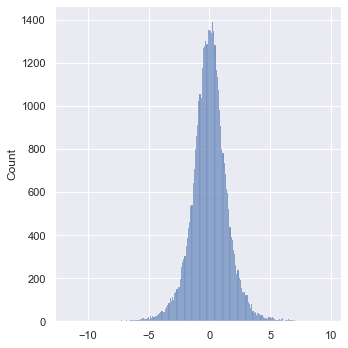

In [15]:
sns.displot(torch.cat((z_1, z_2), 0).flatten().detach().cpu().numpy())

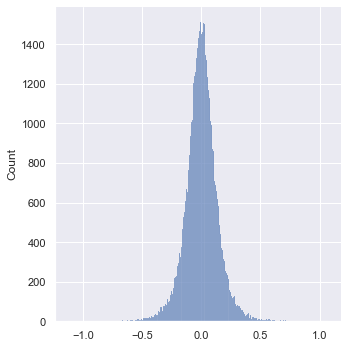

In [16]:
sns.displot(torch.cat((z_base_1, z_base_2), 0).flatten().detach().cpu().numpy())

In [17]:
valPear = np.array(valPear)
valPearDirect = np.array(valPearDirect)
crossCorrelation = np.array(crossCorrelation)
valSpear = np.array(valSpear)
valAccuracy= np.array(valAccuracy)
valSpearDirect= np.array(valSpearDirect)
valAccDirect= np.array(valAccDirect)

In [18]:
print(np.mean(valPear,axis=0))
print(np.mean(valPearDirect))

[0.69599968 0.64834788]
0.45795060992240905


In [19]:
print(np.mean(valSpear,axis=0))
print(np.mean(valSpearDirect))

[0.60461412 0.57966662]
0.40821883215419613


In [20]:
print(np.mean(valAccuracy,axis=0))
print(np.mean(valAccDirect,axis=0))

[0.71246421 0.7058998 ]
[0.64107618 0.64107618]


In [21]:
print(np.mean(valF1))
print(np.mean(valClassAcc))

1.0
1.0


In [22]:
df_result = pd.DataFrame({'F1_score':valF1,'ClassAccuracy':valClassAcc,
                          'model_pearsonHT29':valPear[:,0],'model_pearsonA375':valPear[:,1],
                          'model_spearHT29':valSpear[:,0],'model_spearA375':valSpear[:,1],
                          'model_accHT29':valAccuracy[:,0],'model_accA375':valAccuracy[:,1],
                          'recon_pear_ht29':valPear_2 ,'recon_pear_a375':valPear_1,
                          'recon_spear_ht29':valSpear_2 ,'recon_spear_a375':valSpear_1,
                          'recon_acc_ht29':valAccuracy_2 ,'recon_acc_a375':valAccuracy_1,
                          'Direct_pearson':valPearDirect,'Direct_spearman':valSpearDirect,
                          'DirectAcc_ht29':valAccDirect[:,0],'DirectAcc_a375':valAccDirect[:,1]})
df_result

,F1_score,ClassAccuracy,model_pearsonHT29,model_pearsonA375,model_spearHT29,model_spearA375,model_accHT29,model_accA375,recon_pear_ht29,recon_pear_a375,recon_spear_ht29,recon_spear_a375,recon_acc_ht29,recon_acc_a375,Direct_pearson,Direct_spearman,DirectAcc_ht29,DirectAcc_a375
0,1.0,1.0,0.744946,0.647801,0.659541,0.600114,0.730496,0.714340,0.810811,0.795488,0.747146,0.726701,0.783296,0.773023,0.520686,0.463031,0.662730,0.662730
1,1.0,1.0,0.693744,0.685379,0.598586,0.590397,0.710251,0.713088,0.801183,0.784427,0.729980,0.709485,0.775748,0.765158,0.479417,0.420304,0.649847,0.649847
2,1.0,1.0,0.789342,0.743238,0.691196,0.666481,0.743021,0.740900,0.773252,0.800462,0.711710,0.730880,0.764668,0.774199,0.500422,0.432608,0.644836,0.644836
3,1.0,1.0,0.694324,0.664346,0.575898,0.570811,0.703579,0.706186,0.788082,0.791576,0.711529,0.708254,0.769836,0.765815,0.445524,0.393393,0.635890,0.635890
4,1.0,1.0,0.736065,0.704153,0.634498,0.618352,0.723799,0.715133,0.812644,0.798279,0.758641,0.718400,0.795585,0.769973,0.542872,0.442503,0.653144,0.653144
5,1.0,1.0,0.682038,0.643637,0.611858,0.582229,0.723134,0.709867,0.812387,0.801845,0.752804,0.737822,0.794116,0.781944,0.456026,0.433163,0.654525,0.654525
6,1.0,1.0,0.645892,0.568682,0.555579,0.520047,0.691334,0.678783,0.813070,0.786678,0.747748,0.725985,0.791299,0.773739,0.391251,0.353916,0.618405,0.618405
7,1.0,1.0,0.694768,0.648252,0.642995,0.606206,0.730752,0.714315,0.827602,0.780485,0.773780,0.728709,0.806432,0.778758,0.455651,0.433182,0.652428,0.652428
8,1.0,1.0,0.640344,0.576175,0.519874,0.501132,0.677480,0.674080,0.797780,0.785279,0.744023,0.732776,0.785704,0.777607,0.373686,0.337688,0.610148,0.610148
9,1.0,1.0,0.638535,0.601817,0.556115,0.540897,0.690798,0.692306,0.785988,0.770981,0.724263,0.717916,0.772430,0.770671,0.413972,0.372399,0.628809,0.628809


In [23]:
df_result.to_csv('../results/MI_results/landmarks_10foldvalidation_withIntermediate2Dec_1000ep512bs_a375_ht29.csv')

## Get predictions and embeddings

In [25]:
for i in range(10):
    # Network
    encoder_1 = torch.load('../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/encoder_a375_%s.pt'%i)
    encoder_2 = torch.load('../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/encoder_ht29_%s.pt'%i)
    encoder_interm_1 = torch.load('../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/encoder_interm_a375_%s.pt'%i)
    encoder_interm_2 = torch.load('../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/encoder_interm_ht29_%s.pt'%i)
    decoder_1 = torch.load('../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/decoder_a375_%s.pt'%i)
    decoder_2 = torch.load('../results/MI_results/models/IntermediateTranslationLandmarks2Dec_1000ep/decoder_ht29_%s.pt'%i)
    
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i,index_col=0)
    trainInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%i,index_col=0)
    trainInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%i,index_col=0)
    
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)
    valInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i,index_col=0)
    valInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i,index_col=0)
    
    encoder_1.eval()
    encoder_2.eval()
    encoder_interm_1.eval()
    encoder_interm_2.eval()
    decoder_1.eval()
    decoder_2.eval()
    
    paired_val_inds = len(valInfo_paired)
    x_1 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.x']].values,
                                          cmap.loc[valInfo_1.sig_id].values))).float().to(device)
    x_2 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.y']].values,
                                          cmap.loc[valInfo_2.sig_id].values))).float().to(device)
    
    z_base_1 = encoder_1(x_1)
    z_base_2 = encoder_2(x_2)
    
    z_latent_1 = encoder_interm_1(z_base_1)
    z_latent_2 = encoder_interm_2(z_base_2)
    
    xhat1 = decoder_1(z_latent_1)
    xhat2 = decoder_2(z_latent_2)

    valPreds_1 = pd.DataFrame(xhat1.detach().cpu().numpy())
    valPreds_1.index = np.concatenate((valInfo_paired['sig_id.x'].values,valInfo_1.sig_id.values))
    valPreds_2 = pd.DataFrame(xhat2.detach().cpu().numpy())
    valPreds_2.index = np.concatenate((valInfo_paired['sig_id.y'].values,valInfo_2.sig_id.values))
    
    valEmbs_1 = pd.DataFrame(z_latent_1.detach().cpu().numpy())
    valEmbs_1.index = np.concatenate((valInfo_paired['sig_id.x'].values,valInfo_1.sig_id.values))
    valEmbs_2 = pd.DataFrame(z_latent_2.detach().cpu().numpy())
    valEmbs_2.index = np.concatenate((valInfo_paired['sig_id.y'].values,valInfo_2.sig_id.values))
    
    valEmbs_base_1 = pd.DataFrame(z_base_1.detach().cpu().numpy())
    valEmbs_base_1.index = np.concatenate((valInfo_paired['sig_id.x'].values,valInfo_1.sig_id.values))
    valEmbs_base_2 = pd.DataFrame(z_base_2.detach().cpu().numpy())
    valEmbs_base_2.index = np.concatenate((valInfo_paired['sig_id.y'].values,valInfo_2.sig_id.values))
    
    # Training embeddigns
    paired_inds = len(trainInfo_paired)
    x_1 = torch.tensor(np.concatenate((cmap.loc[trainInfo_paired['sig_id.x']].values,
                                          cmap.loc[trainInfo_1.sig_id].values))).float().to(device)
    x_2 = torch.tensor(np.concatenate((cmap.loc[trainInfo_paired['sig_id.y']].values,
                                          cmap.loc[trainInfo_2.sig_id].values))).float().to(device)
    z_base_1 = encoder_1(x_1)
    z_base_2 = encoder_2(x_2)
    
    z_latent_1 = encoder_interm_1(z_base_1)
    z_latent_2 = encoder_interm_2(z_base_2)
    
    # Training predictions
    xhat1 = decoder_1(z_latent_1)
    xhat2 = decoder_2(z_latent_2)

    trainPreds_1 = pd.DataFrame(xhat1.detach().cpu().numpy())
    trainPreds_1.index = np.concatenate((trainInfo_paired['sig_id.x'].values,trainInfo_1.sig_id.values))
    trainPreds_2 = pd.DataFrame(xhat2.detach().cpu().numpy())
    trainPreds_2.index = np.concatenate((trainInfo_paired['sig_id.y'].values,trainInfo_2.sig_id.values))
    
    trainEmbs_1 = pd.DataFrame(z_latent_1.detach().cpu().numpy())
    trainEmbs_1.index = np.concatenate((trainInfo_paired['sig_id.x'].values,trainInfo_1.sig_id.values))
    trainEmbs_2 = pd.DataFrame(z_latent_2.detach().cpu().numpy())
    trainEmbs_2.index = np.concatenate((trainInfo_paired['sig_id.y'].values,trainInfo_2.sig_id.values))
    
    trainEmbs_base_1 = pd.DataFrame(z_base_1.detach().cpu().numpy())
    trainEmbs_base_1.index = np.concatenate((trainInfo_paired['sig_id.x'].values,trainInfo_1.sig_id.values))
    trainEmbs_base_2 = pd.DataFrame(z_base_2.detach().cpu().numpy())
    trainEmbs_base_2.index = np.concatenate((trainInfo_paired['sig_id.y'].values,trainInfo_2.sig_id.values))
    
    valEmbs_1.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/validation/valEmbs_%s_a375.csv'%i)
    valEmbs_2.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/validation/valEmbs_%s_ht29.csv'%i)
    trainEmbs_1.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/train/trainEmbs_%s_a375.csv'%i)
    trainEmbs_2.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/train/trainEmbs_%s_ht29.csv'%i)
    
    valEmbs_base_1.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/validation/valEmbs_base_%s_a375.csv'%i)
    valEmbs_base_2.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/validation/valEmbs_base_%s_ht29.csv'%i)
    trainEmbs_base_1.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/train/trainEmbs_base_%s_a375.csv'%i)
    trainEmbs_base_2.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/train/trainEmbs_base_%s_ht29.csv'%i)
    
    valPreds_1.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/validation/valPreds_%s_a375.csv'%i)
    valPreds_2.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/validation/valPreds_%s_ht29.csv'%i)
    trainPreds_1.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/train/trainPreds_%s_a375.csv'%i)
    trainPreds_2.to_csv('../results/MI_results/embs/IntermediateTranslationLandmarks2Dec_1000ep/train/trainPreds_%s_ht29.csv'%i)